## Install Libraries

In [25]:
%pip install -U weaviate-client plotly numpy
%pip install --upgrade nbformat kaleido

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [26]:
import os
import requests, json
import weaviate
import numpy as np
from weaviate.classes.config import Configure, VectorDistances
import weaviate.classes as wvc

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import plotly.express as px


## Create Schema and Populate DSM Data

In [27]:
client = weaviate.connect_to_local()
try:
    dsm = client.collections.create(
        name="DSM",
        vector_config=Configure.Vectors.text2vec_transformers(
            name="text_vector",
            source_properties=["text"],
            vector_index_config=Configure.VectorIndex.hnsw(
                # https://docs.weaviate.io/weaviate/config-refs/distances
                distance_metric=VectorDistances.COSINE
            ),
        ),
    )

    directory = "./chunks"
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".json"):
            with open(os.path.join(directory, filename)) as f:
                jsn = json.loads(f.read())

                cks = jsn["chunks"]
                for i,c in enumerate(cks):
                    with dsm.batch.dynamic() as batch:
                        batch.add_object(
                            {
                                "key": f"{jsn['id']}::{i}",
                                "title": jsn["title"],
                                "text": c,
                            }
                        )
except Exception as ex:
    print("probably already exists", ex)
finally:
    client.close()

## Tests Query

In [ ]:
# client = weaviate.connect_to_weaviate_cloud(
#     cluster_url=weaviate_url,                                    # Replace with your Weaviate Cloud URL
#     # auth_credentials=wvc.init.Auth.api_key(weaviate_api_key),    # Replace with your Weaviate Cloud key
#     # headers={"X-OpenAI-Api-Key": openai_api_key}            # Replace with appropriate header key/value pair for the required API
# )
client = weaviate.connect_to_local()
try:
    collection = client.collections.use("DSM")

    # results = collection.query.hybrid(
    #     # https://deepwiki.com/weaviate/weaviate-python-client/5.2-keyword-and-hybrid-search
    #     return_metadata=wvc.query.MetadataQuery(
    #         score=True,
    #         explain_score=True,
    #         distance=True,
    #         certainty=True
    #     ),
    #     query="patient has been complaining of lack of sleep and low mood",
    #     alpha=0.5,  # Equal balance between BM25 and vector search
    #     target_vector="text_vector",
    #     limit=4,
    # )
    # pprint.pprint(results)

    # response = collection.query.bm25()
    # https://deepwiki.com/weaviate/weaviate/6.2-keyword-search-(bm25)
    # https://medium.com/etoai/hybrid-search-combining-bm25-and-semantic-search-for-better-results-with-lan-1358038fe7e6

    results = collection.query.near_text(
       # Because near_text is a purely vector search, you get a distance instead of a score.
        return_metadata=wvc.query.MetadataQuery(
            score=True, explain_score=True, distance=True, certainty=True
        ),
        query="patient complains of inablity to stay asleep, low mood, and doesn't care about day to day activities",
        limit=4
    )
    for r in results.objects:
        print(f"distance: {r.metadata.distance}, certainty: {r.metadata.certainty}, score: {round((1-r.metadata.distance)*100, 1)}%")
        print(r.properties['title'])
        print(r.properties['text'][:180].replace("\n",""))
        print("----------------------------")

finally:
    client.close()  # Close client gracefully

# Most text embeddings (e.g., from BERT, Sentence-BERT, etc.) are normalized, so cosine similarity is between 0 and 1.

distance: 0.05510437488555908, certainty: 0.9724478125572205, score: 94.5%
Trauma- and Stressor-Related Disorders
In children, distress may be expressed in play and behavior, developmental regressions, and anxious or protest behavior at times of separation and reunion. Young children may exper
----------------------------
distance: 0.05539822578430176, certainty: 0.9723008871078491, score: 94.5%
Cluster C Personalit Disorders y
Individuals with obsessive-compulsive personality disorder display excessive devotion to work and productivity to the exclusion or devaluing of leisure activities and friendships (
----------------------------
distance: 0.05620396137237549, certainty: 0.9718980193138123, score: 94.4%
Neurocognitive Disorders
###### **Associated Features**  Delirium is often associated with a disturbance in the sleep-wake cycle. This disturbance can include daytime sleepiness, nighttime agitation, diffi
----------------------------
distance: 0.05655503273010254, certainty: 0.9717

## Fetch All Vectors

In [ ]:
client = weaviate.connect_to_local()
try:
    dsm = client.collections.get("DSM")
    response = dsm.query.fetch_objects(limit=10000, include_vector=True)

    vectors = np.array([np.array(obj.vector["text_vector"]) for obj in response.objects])
    titles = np.array(np.array([obj.properties["title"] for obj in response.objects]))

    print(f"Fetched {len(vectors)} vectors.")
except Exception as ex:
    print(f"Error: {ex}")
finally:
    client.close()

unique_titles = list(set(titles))

Fetched 1957 vectors.


## Average Pairwise Distance

My guess is a tightly clustered vector space (where most vectors are close to each other) will indicate poor discriminative power, especially if the clusters overlap or lack clear separation. I think this will lead to worse classification performance.

Calculate the average distance between all pairs of vectors. If this value is small, the vectors are tightly clustered.

**Interpretation**
- Low average distance (e.g., close to 0 for cosine distance): Vectors are tightly clustered.
- High average distance (e.g., close to 1 for cosine distance): Vectors are spread out.

In [34]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np

# Assume `vectors` is your numpy array of embeddings
distance_matrix = cosine_distances(vectors)
avg_distance = np.mean(distance_matrix)
print(f"Average pairwise distance: {avg_distance:.3f}")


Average pairwise distance: 0.042


## Eigenvalue Decay of the Distance Matrix

If the vector space is tightly clustered, the eigenvalues of the distance matrix will decay slowly (indicating low-dimensional structure). This is related to Multidimensional Scaling (MDS).
Steps:

- Compute the distance matrix.
- Perform eigenvalue decomposition.
- Plot the eigenvalues to see how quickly they decay.

**Interpretation**
- Slow decay (flat curve): Vectors are tightly clustered (low-dimensional structure).
- Fast decay (steep curve): Vectors are spread out (high-dimensional structure).

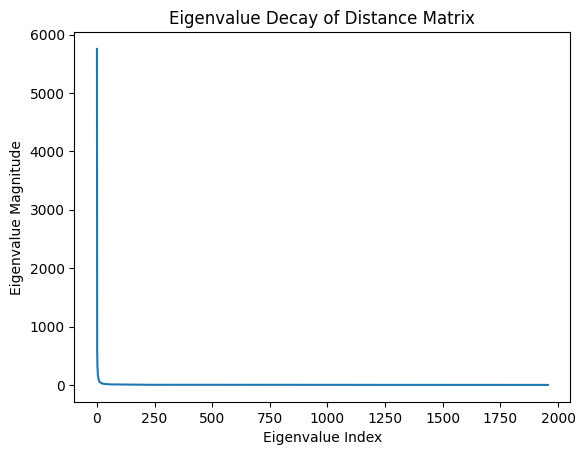

In [35]:
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import eigh

# Compute pairwise Euclidean distances
distance_matrix = squareform(pdist(vectors, 'euclidean'))
eigenvalues = eigh(distance_matrix)[0]
eigenvalues = np.sort(np.abs(eigenvalues))[::-1]  # Sort in descending order

# Plot eigenvalue decay
plt.plot(eigenvalues)
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue Magnitude")
plt.title("Eigenvalue Decay of Distance Matrix")
plt.show()

## Silhouette Score

The silhouette score measures how similar a vector is to its own cluster compared to other clusters. You can use it even if you don’t have true labels by applying k-means first.

**Interpretation**
- Score close to 1: Vectors are well-separated into distinct clusters.
- Score close to 0 or negative: Vectors are tightly clustered or overlapping.

----

- Silhouette Score > 0.5 Clusters are well-separated.
- Adjusted Rand Index > 0.7 K-means clusters align well with true categories.
- Normalized Mutual Info > 0.7 High agreement between clusters and categories.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = len(unique_titles) # 5  # Number of clusters
labels = KMeans(n_clusters=k, random_state=42).fit_predict(vectors)
score = silhouette_score(vectors, labels, metric='cosine')
print(f"Silhouette score: {score:.3f}")


# Compares the k-means cluster assignments to your true category labels.
# - Score close to 1: Cluster assignments match the true categories well.
# - Score close to 0: Cluster assignments are random relative to the true categories.
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(titles, labels)
print(f"Adjusted Rand Index: {ari:.3f}")
##
# Measures the mutual dependence between the k-means clusters and true categories.
# - Score close to 1: High agreement between clusters and categories.
# - Score close to 0: No agreement.
from sklearn.metrics import normalized_mutual_info_score
nmi = normalized_mutual_info_score(titles, labels)
print(f"Normalized Mutual Information: {nmi:.3f}")


Silhouette score: 0.114
Adjusted Rand Index: 0.065
Normalized Mutual Information: 0.284


## PCA and Graph DSM Data

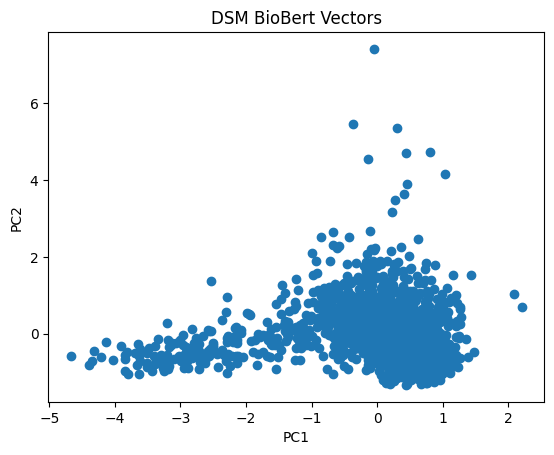

In [ ]:
np.random.seed(42)
# PCA can show relative structure (e.g., tight vs. loose clusters)
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(vectors)

# unique_titles = list(set(titles))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_titles)))

plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1])
plt.title("DSM BioBert Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [33]:
fig = px.scatter_3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    color=titles,
    title="DSM BioBert Vectors",
    size_max=3,
    opacity=0.7
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(
    width=1200,   # in pixels
    height=800,   # in pixels
    title_font_size=20,
)
fig.show()

fig.write_html("graphs/pca_plot_version1.html")
fig.write_image(
    "graphs/pca_plot_version1.png",
    width=1200,
    height=800,
    scale=1
)


/Users/robrohan/miniconda3/envs/spikes/lib/python3.11/site-packages/plotly/io/_kaleido.py:510: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




## Scoring Ideas
- Precision/Recall: retrieving top-k results, calculate precision/recall for each model
- Ranking Metrics: metrics like Mean Reciprocal Rank (MRR) or Normalized Discounted Cumulative Gain (NDCG)

> "Which BERT model gives the most accurate results for my labeled data?"

### Mean Reciprocal Rank (MRR)

The position of the first correct result is important

For each query, find the rank of the first correct result. The Reciprocal Rank (RR) is $1 / rank$. MRR is the average RR across all queries.

Example: Suppose you have 3 queries:
- Query 1: Correct result is ranked 1st → RR = 1/1 = 1.0
- Query 2: Correct result is ranked 3rd → RR = 1/3 ≈ 0.33
- Query 3: Correct result is ranked 2nd → RR = 1/2 = 0.5

$$
MRR = (1.0 + 0.33 + 0.5) / 3 ≈ 0.61
$$

### Normalized Discounted Cumulative Gain (NDCG)

NDCG is a ranking metric that measures the quality of the _entire ranked list_, not just the top result.

- For each position in the ranked list, calculate: DCG = sum((2^relevance - 1) / log2(rank + 1))
- relevance is typically a binary (0/1) or graded score (e.g., 1/2/3).
- The DCG of the perfect ranking (correct results sorted by relevance).
- Normalizes the score to [0, 1], where 1 is perfect.

Example:

- Rank 1: (2^1 - 1) / log2(1+1) = 1 / 1 = 1.0
- Rank 2: (2^0 - 1) / log2(2+1) = 0 / 1.58 ≈ 0
- Rank 3: (2^3 - 1) / log2(3+1) = 7 / 2 ≈ 3.5
- Rank 4: (2^2 - 1) / log2(4+1) = 3 / 2.32 ≈ 1.29
- $DCG = 1.0 + 0 + 3.5 + 1.29 ≈ 5.79$
